In [37]:
def importAsDF(files, de):
    """
    This Method imports a filelist of txt documents as dataframe
    @param files: a list of files in txt format
    @param de: boolean, if set True the language of the files is set german otherwise english
    @return: dataframe that enlists the txtdocuments content sorted by job, company, job description, language
    """
    startdfs = [0 for x in range(len(files))]

    #import txt files as dataframes
    for i in range(len(files)):
        df= pd.read_csv(files[i], delimiter = "\t", header = None)
        startdfs[i]=df
    #create a more sorted df
    lang_dict = {}
    job_dict = {}
    company_dict = {}
    descr_dict = {}

    for j in range(len(startdfs)):
        #current df
        df = startdfs[j]
        #set language
        if de:
            lang ="de"
        else:
            lang= "en"
        lang_dict[j]= lang;
        #set job
        job = df.iloc[0,0]
        job_dict[j]= job
        #set company
        company = df.iloc[1,0]
        company_dict[j]= company;
        #set description - rest of the dataframe
        descr = ""
        for i in range(2,len(df.index)):
            descr = descr + " "+ df.iloc[i,0].strip("◾")
        descr_dict[j] = descr
    #convert dicts to series
    lang_series = pd.Series(lang_dict)
    job_series = pd.Series(job_dict)
    company_series = pd.Series(company_dict)
    descr_series = pd.Series(descr_dict)
    #convert series to df
    df = pd.DataFrame({'job':job_series, 'company':company_series, 'description':descr_series, 'language':lang_series,})
    return df

In [74]:
def getjobdescriptions(df):
    """
    This Method puts all jobdescriptions of a df into one string
    @param df: The Job dataframe from which to take the descriptions from
    @return: string filled with all job descriptions at once
    """
    #get all descriptions
    descrstr = ""
    for i in range(len(df)):
        descrstr =descrstr +" "+ df.iloc[i,2]
    return (removespecials(descrstr))

In [39]:

def getjobdescriptionsaslist(df):
    """
    This Method puts all jobdescriptions of a df into one list of strings
    @param df: The Job dataframe from which to take the descriptions from
    @return: list of strings filled with all job descriptions doc by doc
    """
    #get all descriptions
    descrstr = []
    for i in range(len(df)):
        newstr = removespecials(df.iloc[i,2].lower())
        descrstr += [newstr]
    return descrstr

In [40]:

def removespecials(str):
    """
    This Method removes specialcaracters
    @param str: the string from whom those specialcharacters shall be removed
    @return: string without those specialcaracters
    """
    return str.replace("◾", "").replace("(", "").replace(")", "").replace("[", "").replace("]", "")

In [41]:

def firstspacy(descrstr, de):
    """
    This Method takes a string and returns a dataframe with counted occurence of propernouns. It detects compound nouns and counts them as those compound nouns but not as single nouns
    @param str: the string win which to found nouns
    @param de:  boolean, if set True the language of the files is set german otherwise english
    @return: dataframe of single proper nouns and compound proper nouns and their count
    """
    #let the spacy magic begin ^^
    import spacy
    from spacy.tokens import Doc
    from spacy.lang.de import German
    from spacy.lang.en import English
    
    if(de):
        nlp = spacy.load("de_core_news_sm")
    else:
        nlp = spacy.load("en_core_web_sm") 
    
    nlp.max_length = 2000000
    doc = nlp(descrstr)

    #Matching
    from spacy.matcher import Matcher

    #get compound proper nouns
    matcher = Matcher(nlp.vocab)
    pattern = [{"POS": "PROPN"}, {"POS": "PROPN"}]
    matcher.add("pat", [pattern])
    matches = matcher(doc)

    results =  [doc[start:end].text for match_id, start, end in matches]
    
    #put compound proper nouns nouns in dict and count them
    pnounscount = {}
    pnouns = {}
    index = []
    for result in results:
            if result in pnounscount:
                pnounscount[result] = pnounscount[result]+1
            else:
                pnounscount[result] = 1
                pnouns[result] = result
                index +=[result]
                
    #get single proper nouns (matcher seems to not have the functionallity to exclude the ones already counted in the double ones) 
    for i in range(len(doc)):
        token = doc[i]
        addtoken = False
        #first Token has only a right neighbor
        if i == 0:
            rNbor = token.nbor(1)
            if token.pos_ == 'PROPN' and rNbor.pos_ != 'PROPN' and rNbor.pos_ != 'NOUN':
                addtoken = True
        #last Token has only a left neighbor
        elif i == len(doc) -1:
            lNbor = token.nbor(-1)
            if lNbor.pos_ != 'PROPN'and lNbor.pos_ != 'NOUN' and token.pos_ == 'PROPN':
                addtoken = True
        #default Tokens have a right and a left neighbor
        else:
            rNbor = token.nbor(1)
            lNbor = token.nbor(-1)
            if lNbor.pos_ != 'PROPN' and lNbor.pos_ != 'NOUN' and token.pos_ == 'PROPN' and rNbor.pos_ != 'PROPN' and rNbor.pos_ != 'NOUN':
                addtoken = True

        if addtoken:
            if token.text in pnounscount:
                pnounscount[token.text] = pnounscount[token.text]+1
            else:
                pnounscount[token.text] = 1
                pnouns[token.text] = token.text
                index +=[token.text]
            addtoken = False
    
    #convert to series and dataframe, sort by count column descending
    pncount = pd.Series(pnounscount)
    pn = pd.Series(pnouns)
    df = pd.DataFrame({'count':pncount, 'term':pn}, index = index)
    df = df.sort_values(by = 'count', ascending = False)
            
    return df

In [42]:

def plot(df):
    """
    This Method plots a dataframe of proper nouns and their counts in a bar diagram
    @param df: dataframe to plot
    """ 
    #Plot 
    import matplotlib.pyplot as plt
    plt.figure()
    plt.ylabel('Anzahl der Nennungen')
    plt.xlabel('Begriff')
    df['count'].plot(kind='bar')

In [67]:

def getDF(files, de):
    """
    This Method uses other methods to take a list of txt files and convert it into a dataframe with proper nouns and their count within those strings
    @param files: a filelist of txt files
    @param de: boolean, true -> german , false -> english
    @return: dataframe that contains propernouns and their count
    """
    df1 = importAsDF(files,de)
    df1.to_csv(r"C:\Users\thegy\Documents\Studium\HS FL 4\Mining\DFs\jobdf.csv", sep=";",decimal=",", index=False)
    descr = getjobdescriptions(df1)
    #descr String nicht lower, replace 3 hauptjob in Beschreibungsstrings
    df = firstspacy(descr, de)
    return df

In [68]:
def dropthings(df):
    
    #get all companys
    df11 = importAsDF(files,True)
    comp = ""
    for i in range(len(df11)):    
        comp = comp +" "+ (df11.iloc[i,1])
        
    droplist = comp.split(" ")
    droplist += ['d','Data Engineer','Data Analyst','Data Scientist', 'and', '€', 'EUR', 'English','Frankfurt','Main','UK']
    
    for i in range(len(droplist)):
        if droplist[i] in df.index:
            df = df.drop(droplist[i])
    return df

In [69]:
"""
Read txt files, count proper nouns (compound proper nouns as well and those compounds explicitly not as single nouns)
Get Dataframe of those nouns and ther count and plot them
"""

#find files
import pandas as pd
import glob

files = glob.glob(r"C:\Users\thegy\Documents\Studium\HS FL 4\Mining\Jobs DE\*.txt")
df = getDF(files, True)

filesen = glob.glob(r"C:\Users\thegy\Documents\Studium\HS FL 4\Mining\Jobs EN\*.txt")
dfen = getDF(filesen, False)

In [70]:
df = dropthings(df)
dfen = dropthings(dfen)

In [71]:
print('Filecount de: ',len(files))
print('Filecount en: ',len(filesen))

Filecount de:  200
Filecount en:  400


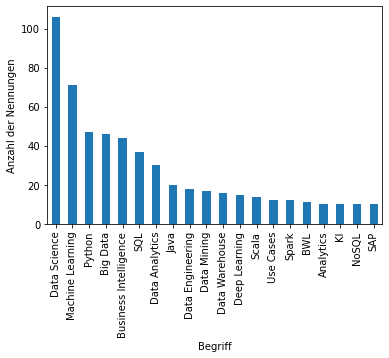

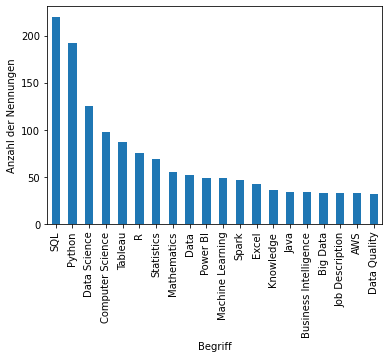

In [72]:
plot(df[:20])
plot(dfen[:20])

In [73]:
df.to_csv(r"C:\Users\thegy\Documents\Studium\HS FL 4\Mining\DFs\nouns_de.csv", sep=";",decimal=",", index=False)
dfen.to_csv(r"C:\Users\thegy\Documents\Studium\HS FL 4\Mining\DFs\nouns_en.csv", sep=";",decimal=",",index=False)